# 1. Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# para encoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
# para calculo del vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# para balanceo de clases
from imblearn.over_sampling import SMOTE
# para modelado
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# para validacion
from sklearn.model_selection import cross_val_score ,train_test_split, StratifiedKFold
from imblearn.pipeline import Pipeline
# para evaluar metricas
from sklearn.metrics import f1_score, make_scorer
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, roc_auc_score
from sklearn.metrics import classification_report
# para optimización de hiperparametros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# para calibrado
from sklearn.calibration import CalibratedClassifierCV

# 2. Carga de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/ONE/HACKATHON/DATASET/DF_FEATURE_ENGINNERING/dataset_feature_enginnering_final.csv')

In [4]:
df.sample(5)

,antiguedad,plan,metodo_pago,tipo_contrato,frecuencia_uso,cambios_plan,facturas_impagas,tickets_soporte,canal_adquisicion,friccion_del_servicio,engagement_score,valor_plan_num,ratio_valor_uso,riesgo_financiero,cliente_problematico,early_churn_risk,premium_mensual,churn
3593,30,estandar,transferencia_bancaria,mensual,22,2,0,3,call_center,0.130435,0.548333,9.99,0.434348,0.00,0,0,0,0
2846,24,estandar,efectivo,mensual,14,2,3,5,referido,0.333333,0.426667,9.99,0.666000,29.97,0,0,0,0
774,60,estandar,transferencia_bancaria,anual,26,0,0,4,call_center,0.148148,0.796667,9.99,0.370000,0.00,0,0,0,0
1601,4,basico,tarjeta_credito,anual,7,2,2,1,call_center,0.125000,0.283333,4.99,0.623750,9.98,0,1,0,0
2814,53,premium,efectivo,anual,15,1,3,9,web,0.562500,0.572500,14.99,0.936875,44.97,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   antiguedad             4251 non-null   int64  
 1   plan                   4251 non-null   object 
 2   metodo_pago            4251 non-null   object 
 3   tipo_contrato          4251 non-null   object 
 4   frecuencia_uso         4251 non-null   int64  
 5   cambios_plan           4251 non-null   int64  
 6   facturas_impagas       4251 non-null   int64  
 7   tickets_soporte        4251 non-null   int64  
 8   canal_adquisicion      4251 non-null   object 
 9   friccion_del_servicio  4251 non-null   float64
 10  engagement_score       4251 non-null   float64
 11  valor_plan_num         4251 non-null   float64
 12  ratio_valor_uso        4251 non-null   float64
 13  riesgo_financiero      4251 non-null   float64
 14  cliente_problematico   4251 non-null   int64  
 15  earl

In [6]:
# Proporcion de churn

df['churn'].value_counts(normalize=True)

,proportion
churn,
0,0.746177
1,0.253823


# 3. Selección de variables explicativas y variable objetivo

In [7]:
X = df.drop(columns='churn')
y = df['churn']

columnas = X.columns

# 4. Encoding

In [8]:
preprocesador = make_column_transformer((OneHotEncoder(drop='first'),
                                         ['plan', 'metodo_pago', 'tipo_contrato', 'canal_adquisicion']),
                                        remainder='passthrough',
                                        sparse_threshold = 0)

X = preprocesador.fit_transform(X)

df_codificado = pd.DataFrame(X, columns= preprocesador.get_feature_names_out(columnas))

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

df_codificado['churn'] = y

print(df_codificado)
print(df_codificado.info())

      onehotencoder__plan_estandar  onehotencoder__plan_premium  \
0                              1.0                          0.0   
1                              1.0                          0.0   
2                              0.0                          1.0   
3                              1.0                          0.0   
4                              1.0                          0.0   
...                            ...                          ...   
4246                           0.0                          1.0   
4247                           1.0                          0.0   
4248                           0.0                          0.0   
4249                           1.0                          0.0   
4250                           1.0                          0.0   

      onehotencoder__metodo_pago_tarjeta_credito  \
0                                            0.0   
1                                            0.0   
2                                      

# 5. Analisis de correlación y multicolinearidad

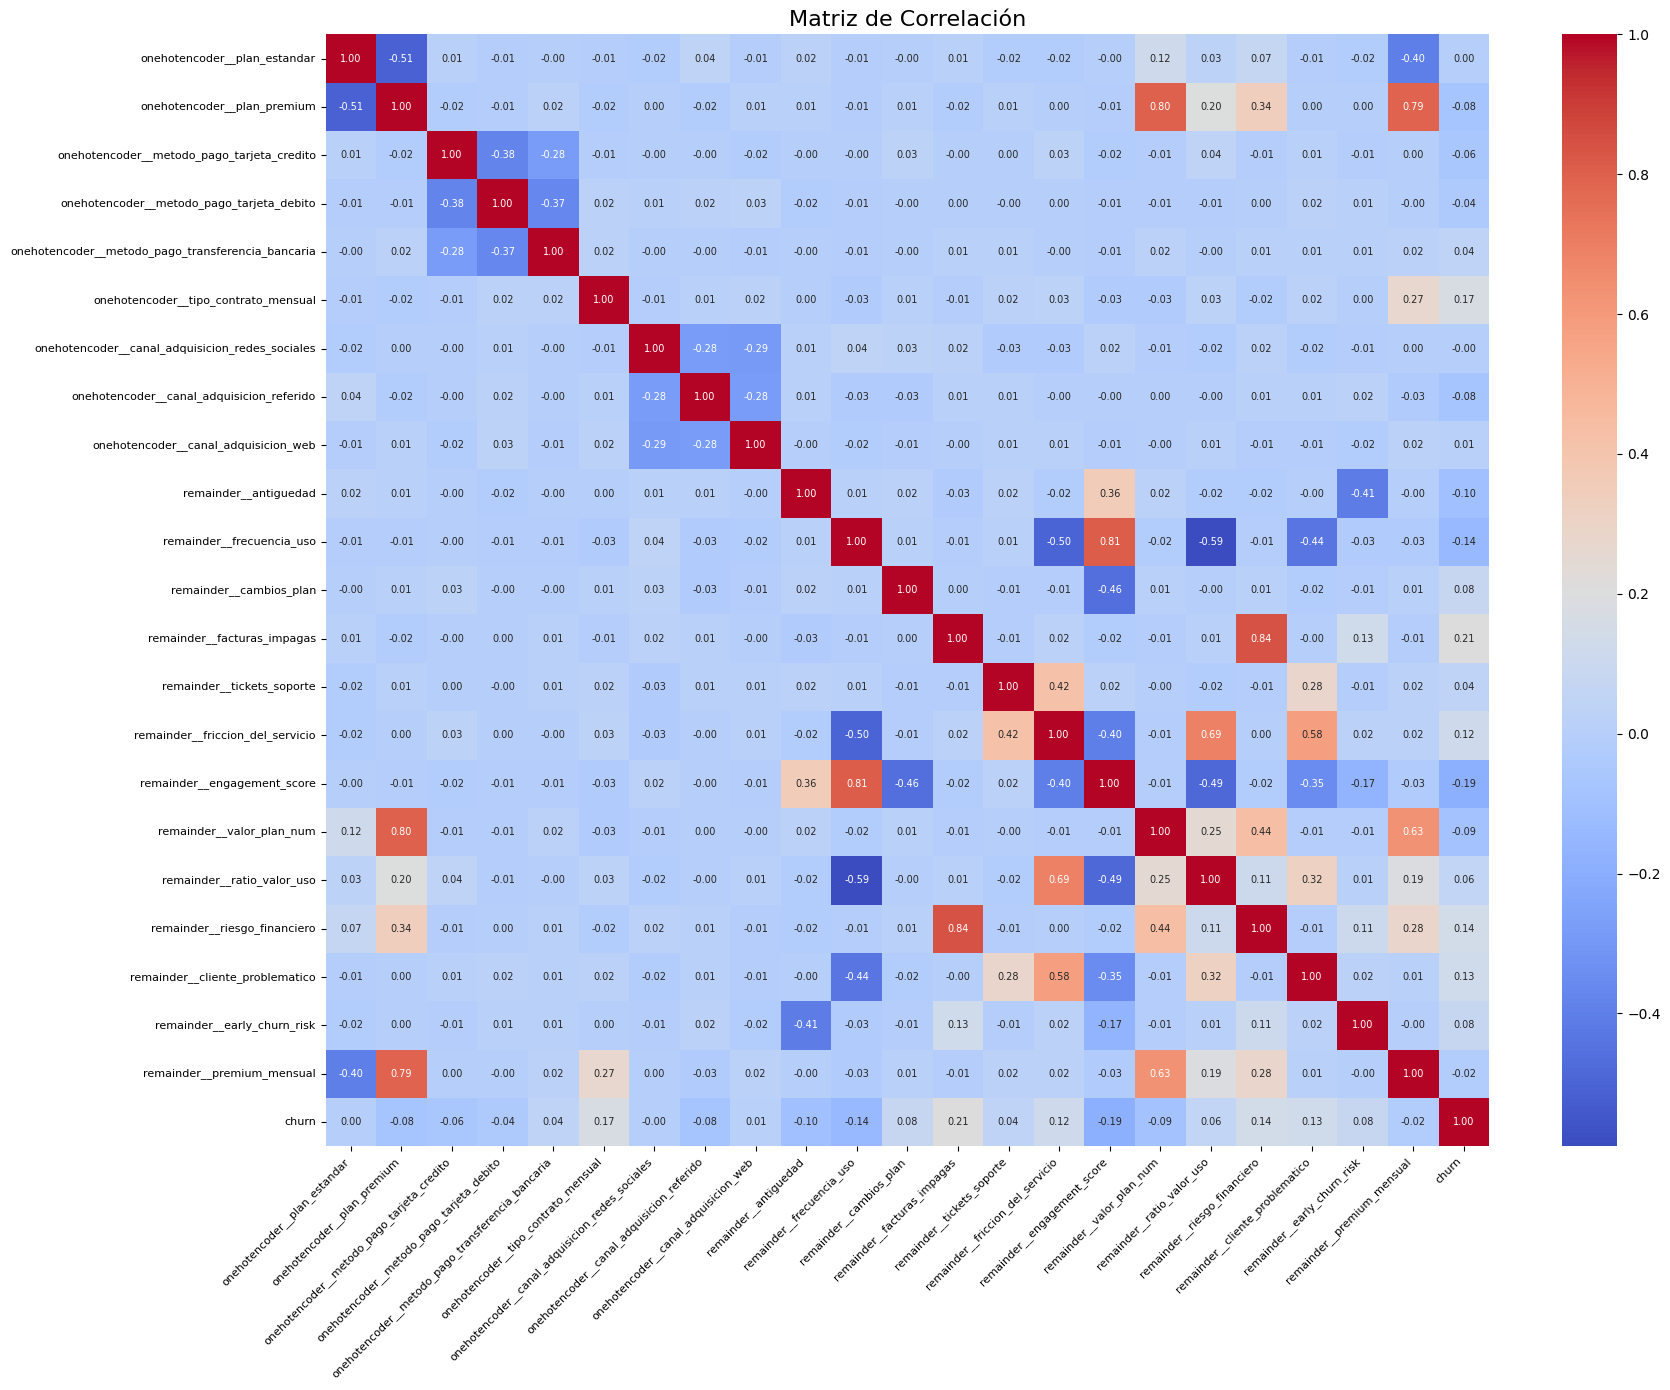

/tmp/ipython-input-408209219.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


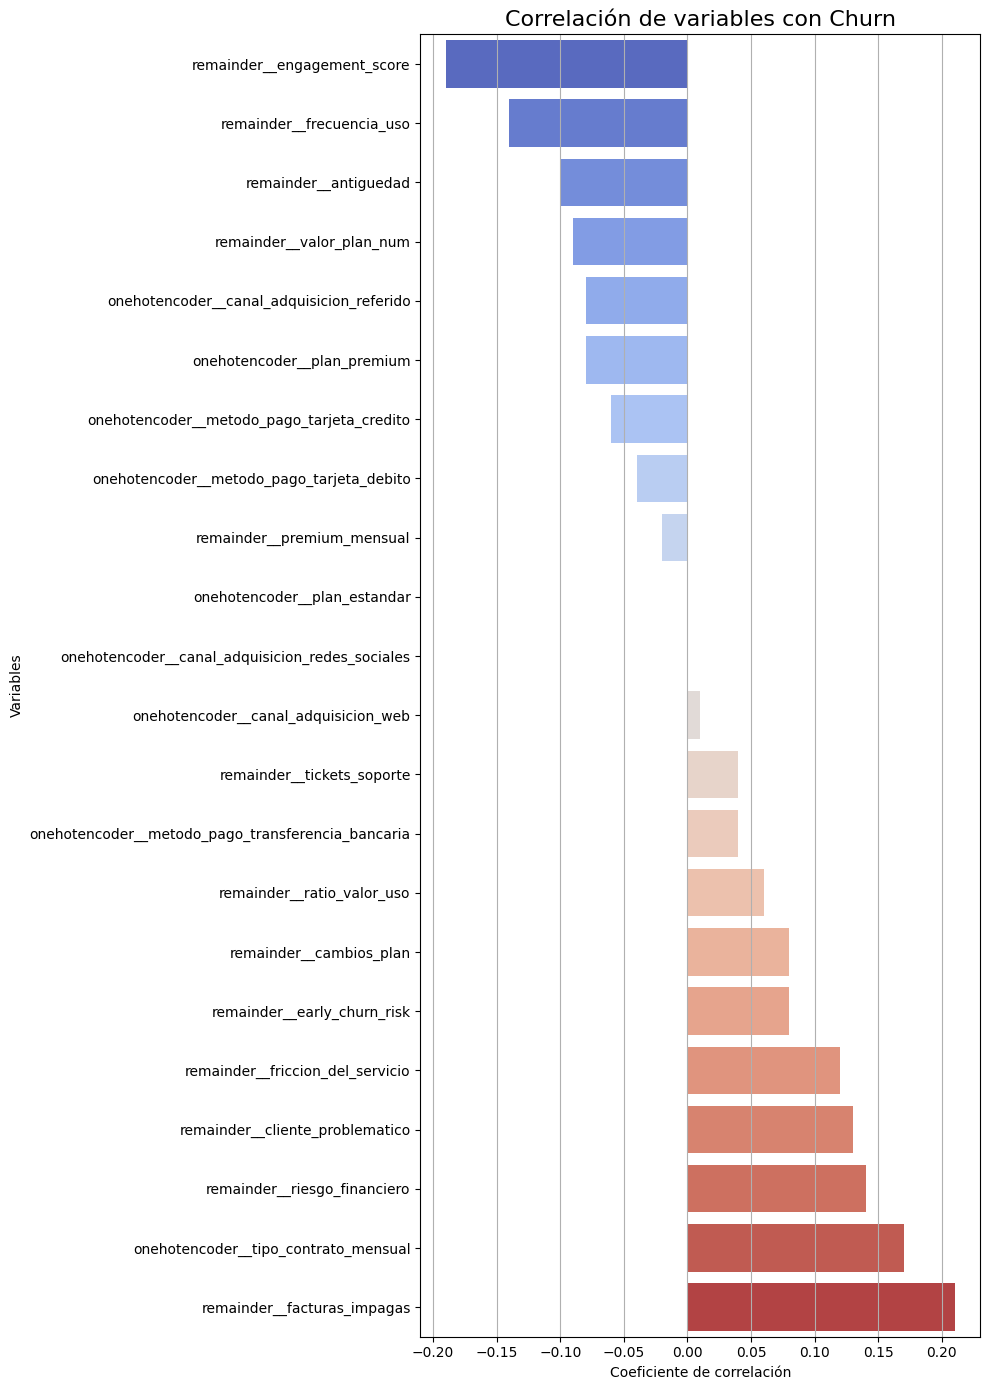

In [9]:
# Analisis de correlación y multicolinearidad

corr = df_codificado.corr().round(2)

plt.figure(figsize=(18, 14))  # definimos el tamaño de figura
sns.heatmap(corr,
            annot=True,         # mostramos los valores de correlación dentro de cada celda
            fmt=".2f",
            cmap='coolwarm',    # paleta de colores
            annot_kws={"size": 7})  # reducimos el tamaño del texto dentro de las celdas

plt.xticks(rotation=45, ha='right', fontsize=8)  # rotamos y achicamos los ticks del eje x
plt.yticks(fontsize=8)                           # tamaño de fuente de los ticks del eje y
plt.title("Matriz de Correlación", fontsize=16)
plt.tight_layout()
plt.show()

# Visualizando mejor las correlaciones con la variable Churn

corr = corr.drop(index='churn').sort_values(by='churn', ascending=True)

plt.figure(figsize=(10, 14))
sns.barplot(
    x='churn',
    y=corr.index,
    data=corr,
    palette='coolwarm'
)
plt.title("Correlación de variables con Churn", fontsize=16)
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 6. Analisis VIF

In [10]:
# variables explicativas
X = df.drop(columns='churn')

# agregar constante
X_const = add_constant(X)

In [11]:
# calcular vif

# Usar el DataFrame codificado para calcular el VIF
X_vif = df_codificado.drop(columns='churn')

# agregar constante
X_vif_const = add_constant(X_vif)

vif_df = pd.DataFrame()
vif_df['feature'] = X_vif_const.columns
vif_df['vif'] = [
    variance_inflation_factor(X_vif_const.values, i)
    for i in range(X_vif_const.shape[1])
]

print(vif_df)

                                              feature        vif
0                                               const   0.000000
1                        onehotencoder__plan_estandar        inf
2                         onehotencoder__plan_premium        inf
3          onehotencoder__metodo_pago_tarjeta_credito   1.552274
4           onehotencoder__metodo_pago_tarjeta_debito   1.658554
5   onehotencoder__metodo_pago_transferencia_bancaria   1.542994
6                onehotencoder__tipo_contrato_mensual   1.287994
7     onehotencoder__canal_adquisicion_redes_sociales   1.297978
8           onehotencoder__canal_adquisicion_referido   1.296366
9                onehotencoder__canal_adquisicion_web   1.297256
10                              remainder__antiguedad        inf
11                          remainder__frecuencia_uso        inf
12                            remainder__cambios_plan        inf
13                        remainder__facturas_impagas   8.287030
14                       

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


#### a) Al hacer el analisis de multicolinearidad, asi como el calculo del VIF, se observo que las features 'engagement_score', 'valor_plan_num' y 'riesgo_financiero' son las mas propensas a sesgar el modelo.

In [12]:
columnas_a_eliminar = ['remainder__engagement_score', 'remainder__valor_plan_num', 'remainder__riesgo_financiero']

In [13]:
X_vif_const = X_vif_const.drop(columns=columnas_a_eliminar)

In [14]:
# Analizando nuevamente el VIF sin las columnas mas 'problematicas'
vif_df = pd.DataFrame()
vif_df['feature'] = X_vif_const.columns
vif_df['vif'] = [
    variance_inflation_factor(X_vif_const.values, i)
    for i in range(X_vif_const.shape[1])
]

print(vif_df)

                                              feature        vif
0                                               const  26.887523
1                        onehotencoder__plan_estandar   1.453716
2                         onehotencoder__plan_premium   3.723671
3          onehotencoder__metodo_pago_tarjeta_credito   1.551551
4           onehotencoder__metodo_pago_tarjeta_debito   1.657355
5   onehotencoder__metodo_pago_transferencia_bancaria   1.542540
6                onehotencoder__tipo_contrato_mensual   1.287885
7     onehotencoder__canal_adquisicion_redes_sociales   1.297598
8           onehotencoder__canal_adquisicion_referido   1.296241
9                onehotencoder__canal_adquisicion_web   1.297032
10                              remainder__antiguedad   1.200901
11                          remainder__frecuencia_uso   1.793841
12                            remainder__cambios_plan   1.003602
13                        remainder__facturas_impagas   1.020173
14                       

### Todas las features muestran un VIF inferior a 5, indicando que no hay una multicolinearidad fuerte.

In [15]:
# Eliminamos las features 'problematicas' del df

df_codificado = df_codificado.drop(columns=columnas_a_eliminar)

df_codificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 20 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   onehotencoder__plan_estandar                       4251 non-null   float64
 1   onehotencoder__plan_premium                        4251 non-null   float64
 2   onehotencoder__metodo_pago_tarjeta_credito         4251 non-null   float64
 3   onehotencoder__metodo_pago_tarjeta_debito          4251 non-null   float64
 4   onehotencoder__metodo_pago_transferencia_bancaria  4251 non-null   float64
 5   onehotencoder__tipo_contrato_mensual               4251 non-null   float64
 6   onehotencoder__canal_adquisicion_redes_sociales    4251 non-null   float64
 7   onehotencoder__canal_adquisicion_referido          4251 non-null   float64
 8   onehotencoder__canal_adquisicion_web               4251 non-null   float64
 9   remainde

In [16]:
# Selección de las variables explicativas y objetivo

X = df_codificado.drop(columns='churn')
y = df_codificado['churn']

# 7. Modelo de Regresión Logistica CON SMOTE

In [17]:
# Balanceo de clases y normalización
oversample = SMOTE(random_state=82)
normalizacion = MinMaxScaler()

In [18]:
# Separación de datos

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=82, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=82)

In [19]:
# Balanceo de clases

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [20]:
# Normalización

X_train_normalize = normalizacion.fit_transform(X_train_smote)
X_test_normalize = normalizacion.transform(X_test)
X_val_normalize = normalizacion.transform(X_val)

In [21]:
# Creando el modelo

modelo_lr = LogisticRegression(max_iter=1000, random_state=82)

modelo_lr.fit(X_train_normalize, y_train_smote)

LogisticRegression(max_iter=1000, random_state=82)

In [22]:
# Validación cruzada
def intervalo_confianza(validacion, nombreModelo):
  promedio = validacion.mean()
  std = validacion.std()
  return f'intervalo de confianza, modelo {nombreModelo}: [{promedio - (2*std)}, {min((promedio + (2*std)), 1)}]'

stratkf = StratifiedKFold(n_splits=5, random_state=82, shuffle=True)

pipeline = Pipeline([('oversample', SMOTE()), ('lr', modelo_lr)])
validacion = cross_val_score(pipeline, X_temp, y_temp, cv=stratkf, scoring='recall')
print(intervalo_confianza(validacion, 'lr'))

intervalo de confianza, modelo lr: [0.5608582496944363, 0.757907713472656]


In [23]:
print(modelo_lr.score(X_train_normalize, y_train_smote))
print(modelo_lr.score(X_test_normalize, y_test))

0.6992610837438423
0.6827262044653349


In [24]:
# Metricas de evaluación

def calcularMetricas(y_true ,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  metricas = {'Accuracy': round(accuracy, 4),
              'F1': round(f1, 4),
              'Recall': round(recall, 4),
              'Precision': round(precision, 4)}
  return metricas

  # Matriz de confusión
def matriz_confusion(y_true, y_pred):
  matriz = confusion_matrix(y_true, y_pred)
  visualizer = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['No desertó', 'Desertó'])
  return visualizer.plot()

{'Accuracy': 0.6779, 'F1': 0.5101, 'Recall': 0.659, 'Precision': 0.4161}


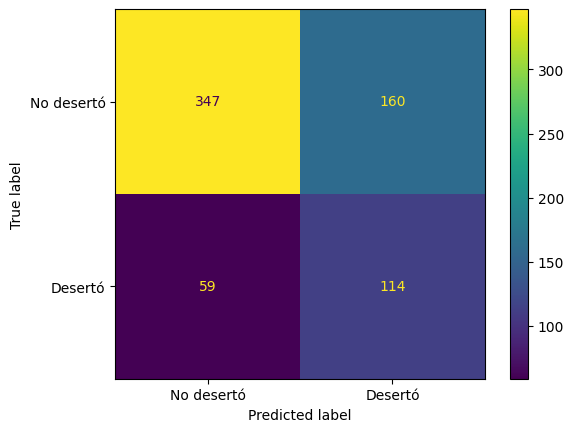

In [25]:
y_pred = modelo_lr.predict(X_val_normalize)
print(calcularMetricas(y_val ,y_pred))

visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Feature importances

In [26]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_norm_df = pd.DataFrame(X_train_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_norm_df = pd.DataFrame(X_val_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)

importancias_lr = pd.DataFrame({
    'Features': X_train_norm_df.columns,
    'Coeficiente': modelo_lr.coef_[0],
    'Importancia': np.abs(modelo_lr.coef_[0])
}).sort_values('Importancia', ascending=False)

print(importancias_lr)


importancias_lr['Importancia_%'] = (
    importancias_lr['Importancia'] / importancias_lr['Importancia'].sum() * 100
).round(2)

importancias_lr = importancias_lr.sort_values('Importancia_%', ascending=False)


print(importancias_lr)

model_features = LogisticRegression(max_iter=1000, random_state=82)

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]

for i in ct_features:
    selected_features = importancias_lr['Features'].values[:i]
    X_train_sel = X_train_norm_df[selected_features]
    X_val_sel = X_val_norm_df[selected_features]

    model_features.fit(X_train_sel, y_train_smote)
    y_previsto = model_features.predict(X_val_sel)

    metricas = calcularMetricas(y_val, y_previsto)
    resultados[i] = list(metricas.values())

print(resultados)


                                             Features  Coeficiente  \
12                        remainder__facturas_impagas     2.043430   
9                               remainder__antiguedad    -1.437843   
5                onehotencoder__tipo_contrato_mensual     1.177782   
10                          remainder__frecuencia_uso    -0.890797   
11                            remainder__cambios_plan     0.830432   
2          onehotencoder__metodo_pago_tarjeta_credito    -0.813869   
7           onehotencoder__canal_adquisicion_referido    -0.800314   
1                         onehotencoder__plan_premium    -0.791913   
16                    remainder__cliente_problematico     0.650784   
3           onehotencoder__metodo_pago_tarjeta_debito    -0.559139   
8                onehotencoder__canal_adquisicion_web    -0.436869   
13                         remainder__tickets_soporte    -0.421128   
6     onehotencoder__canal_adquisicion_redes_sociales    -0.396091   
0                   

### En este caso, se optara por seleccionar las **4 mejores features**

### Segmentando con las mejores features

In [27]:
lr_features = importancias_lr['Features'].values[:4]

X_selected_features = df_codificado[lr_features]

print(lr_features)

['remainder__facturas_impagas' 'remainder__antiguedad'
 'onehotencoder__tipo_contrato_mensual' 'remainder__frecuencia_uso']


In [28]:
# segmentando nuevamente los datos con las mejores features
X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, stratify=y, random_state=82, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=82, test_size=0.2)

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)


X_train_normalize = normalizacion.fit_transform(X_train_smote)
X_val_normalize = normalizacion.transform(X_val)
X_test_normalize = normalizacion.transform(X_test)

## Optimización de hiperparametros

{'C': 0.01, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
{'Accuracy': 0.5544, 'F1': 0.4975, 'Recall': 0.8671, 'Precision': 0.3488}


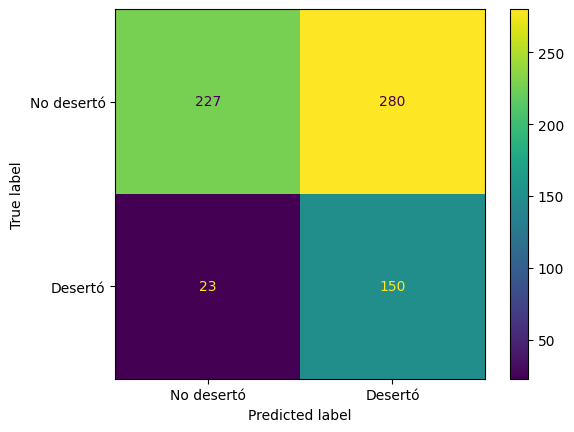

In [29]:
# Grilla de hiperparametros
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None],
    'max_iter': [1000]
}



grid_lr = GridSearchCV(LogisticRegression(random_state=82), param_grid_lr, cv=stratkf, scoring='recall')
grid_lr.fit(X_train_normalize, y_train_smote)

print(grid_lr.best_params_)

# Eligiendo el mejor modelo
best_lr = grid_lr.best_estimator_

best_lr.fit(X_train_normalize, y_train_smote)

# Analisis de metricas
y_pred = best_lr.predict(X_val_normalize)
print(calcularMetricas(y_val, y_pred))
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Curva ROC y PR

0.6954429889067505


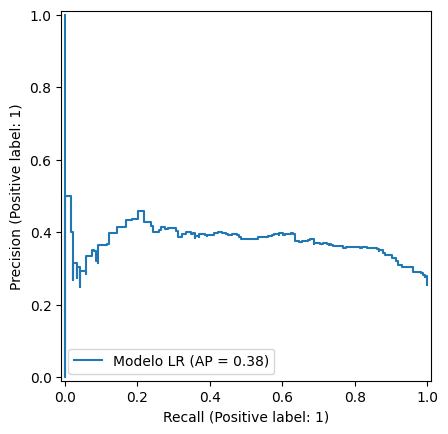

In [30]:
y_pred = best_lr.predict_proba(X_val_normalize)

roc_auc = roc_auc_score(y_val, y_pred[:, 1])
print(roc_auc)
PrecisionRecallDisplay.from_predictions(y_val, y_pred[:, 1], name='Modelo LR')
plt.show()

## Eligiendo el umbral

In [31]:
y_proba = best_lr.predict_proba(X_val_normalize)[:, 1]

In [32]:
y_proba.min(), y_proba.max()

(np.float64(0.41380074426701585), np.float64(0.6033572427686965))

In [33]:
thresholds = np.arange(0.4, 0.66, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.40,0.254412,1.000000,0.405627,680
1,0.41,0.254412,1.000000,0.405627,680
2,0.42,0.257058,1.000000,0.408983,673
3,0.43,0.257824,1.000000,0.409953,671
4,0.44,0.262519,1.000000,0.415865,659
5,0.45,0.269470,1.000000,0.424540,642
6,0.46,0.280130,0.994220,0.437103,614
7,0.47,0.289157,0.971098,0.445623,581
8,0.48,0.309021,0.930636,0.463977,521
9,0.49,0.331210,0.901734,0.484472,471


### **Umbral optimo**: 0.5



## Calibrando las probabilidades

In [34]:
lr_calibrado = CalibratedClassifierCV(
    estimator=best_lr,
    method="sigmoid",
    cv=5
)

In [35]:
lr_calibrado.fit(X_train_normalize, y_train_smote)

CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(C=0.01, max_iter=1000,
                                                    penalty='l1',
                                                    random_state=82,
                                                    solver='liblinear'))

In [36]:
y_proba_cal = lr_calibrado.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [37]:
y_proba_cal.min(), y_proba_cal.max()

(np.float64(0.09677083262308965), np.float64(0.9885588722514461))

In [38]:
thresholds = np.linspace(y_proba_cal.min(), y_proba_cal.max(), 20)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.096771,0.254412,1.000000,0.405627,680
1,0.143707,0.306238,0.936416,0.461538,529
2,0.190643,0.307544,0.919075,0.460870,517
3,0.237579,0.307992,0.913295,0.460641,513
4,0.284516,0.315682,0.895954,0.466867,491
5,0.331452,0.336585,0.797688,0.473413,410
6,0.378388,0.337563,0.768786,0.469136,394
7,0.425324,0.361446,0.693642,0.475248,332
8,0.472261,0.373737,0.641618,0.472340,297
9,0.519197,0.389831,0.531792,0.449878,236


In [39]:
thresholds = np.arange(0.2, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.20,0.307544,0.919075,0.460870,517
1,0.21,0.307544,0.919075,0.460870,517
2,0.22,0.307544,0.919075,0.460870,517
3,0.23,0.307992,0.913295,0.460641,513
4,0.24,0.307992,0.913295,0.460641,513
5,0.25,0.307992,0.913295,0.460641,513
6,0.26,0.307992,0.913295,0.460641,513
7,0.27,0.307992,0.913295,0.460641,513
8,0.28,0.311024,0.913295,0.464023,508
9,0.29,0.329718,0.878613,0.479495,461


### **Umbral optimo**: 0.4

{'Accuracy': 0.6015, 'F1': 0.4697, 'Recall': 0.6936, 'Precision': 0.355}


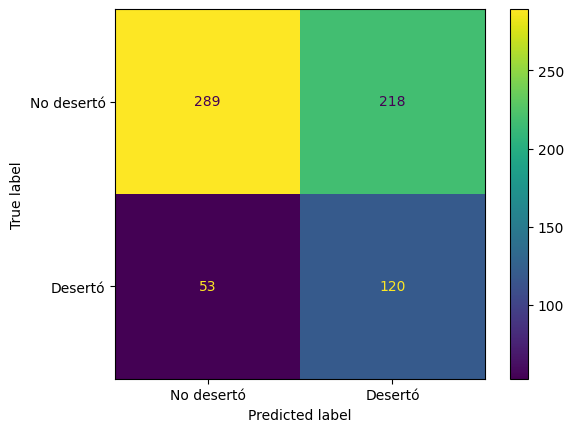

In [40]:
y_pred = lr_calibrado.predict(X_val_normalize)
print(calcularMetricas(y_val, y_pred))
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Curva ROC y PR Post-Calibración

0.668684657568606


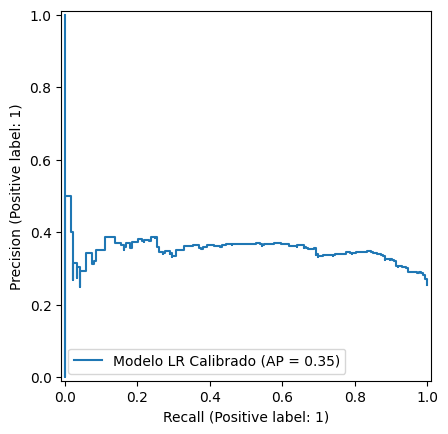

In [41]:
y_pred = lr_calibrado.predict_proba(X_val_normalize)
roc_auc = roc_auc_score(y_val, y_pred[:, 1])
print(roc_auc)

PrecisionRecallDisplay.from_predictions(y_val, y_pred[:, 1], name='Modelo LR Calibrado')
plt.show()

## Nombre de los modelos:

Modelo sin calibrar: **best_lr**

Modelo calibrado: **lr_calibrado**

# Modelo Regresión Logistica SIN SMOTE

In [42]:
# Separación de datos

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=82, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=82)

In [43]:
# Normalización

X_train_normalize = normalizacion.fit_transform(X_train)
X_test_normalize = normalizacion.transform(X_test)
X_val_normalize = normalizacion.transform(X_val)

In [44]:
# Creando el modelo

modelo_lr = LogisticRegression(max_iter=1000, random_state=82, class_weight='balanced')

modelo_lr.fit(X_train_normalize, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=82)

In [45]:
# Validación cruzada

pipeline = Pipeline([('lr', modelo_lr)])
validacion = cross_val_score(pipeline, X_temp, y_temp, cv=stratkf, scoring='recall')
print(intervalo_confianza(validacion, 'lr'))

intervalo de confianza, modelo lr: [0.5769088528691846, 0.7603676627915223]


In [46]:
print(modelo_lr.score(X_train_normalize, y_train))
print(modelo_lr.score(X_test_normalize, y_test))

0.6680147058823529
0.6827262044653349


## Metricas de evaluación/ Matriz de confusión

{'Accuracy': 0.6691, 'F1': 0.5055, 'Recall': 0.6647, 'Precision': 0.4078}


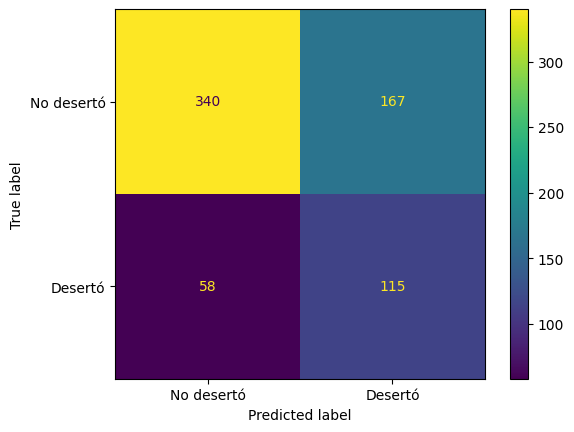

In [47]:
y_pred = modelo_lr.predict(X_val_normalize)
print(calcularMetricas(y_val ,y_pred))

visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Feature Importances

In [48]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_norm_df = pd.DataFrame(X_train_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_norm_df = pd.DataFrame(X_val_normalize, columns=df_codificado.drop(columns='churn', axis=1).columns)

importancias_lr = pd.DataFrame({
    'Features': X_train_norm_df.columns,
    'Coeficiente': modelo_lr.coef_[0],
    'Importancia': np.abs(modelo_lr.coef_[0])
}).sort_values('Importancia', ascending=False)

print(importancias_lr)


importancias_lr['Importancia_%'] = (
    importancias_lr['Importancia'] / importancias_lr['Importancia'].sum() * 100
).round(2)

importancias_lr = importancias_lr.sort_values('Importancia_%', ascending=False)


print(importancias_lr)

model_features = LogisticRegression(max_iter=1000, random_state=82, class_weight='balanced')

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]
resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

for i in ct_features:
    selected_features = importancias_lr['Features'].values[:i]
    X_train_sel = X_train_norm_df[selected_features]
    X_val_sel = X_val_norm_df[selected_features]

    model_features.fit(X_train_sel, y_train)
    y_previsto = model_features.predict(X_val_sel)

    metricas = calcularMetricas(y_val, y_previsto)
    resultados[i] = list(metricas.values())

print(resultados)


                                             Features  Coeficiente  \
12                        remainder__facturas_impagas     1.752330   
9                               remainder__antiguedad    -1.265493   
5                onehotencoder__tipo_contrato_mensual     1.098458   
10                          remainder__frecuencia_uso    -0.898859   
11                            remainder__cambios_plan     0.723539   
1                         onehotencoder__plan_premium    -0.630916   
7           onehotencoder__canal_adquisicion_referido    -0.609249   
2          onehotencoder__metodo_pago_tarjeta_credito    -0.606765   
16                    remainder__cliente_problematico     0.597304   
3           onehotencoder__metodo_pago_tarjeta_debito    -0.453892   
13                         remainder__tickets_soporte    -0.333367   
6     onehotencoder__canal_adquisicion_redes_sociales    -0.271654   
8                onehotencoder__canal_adquisicion_web    -0.221822   
0                   

### Segmentando con las **7 mejores features**

In [49]:
lr_features = importancias_lr['Features'].values[:7]

X_selected_features = df_codificado[lr_features]

print(lr_features)

['remainder__facturas_impagas' 'remainder__antiguedad'
 'onehotencoder__tipo_contrato_mensual' 'remainder__frecuencia_uso'
 'remainder__cambios_plan' 'onehotencoder__plan_premium'
 'onehotencoder__canal_adquisicion_referido']


In [50]:
# segmentando nuevamente los datos con las mejores features
X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, stratify=y, random_state=82, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=82, test_size=0.2)


X_train_normalize = normalizacion.fit_transform(X_train)
X_val_normalize = normalizacion.transform(X_val)
X_test_normalize = normalizacion.transform(X_test)

## Optimización de hiperparametros

{'C': 0.01, 'class_weight': {0: 1, 1: 3}, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
{'Accuracy': 0.5456, 'F1': 0.4976, 'Recall': 0.8844, 'Precision': 0.3462}


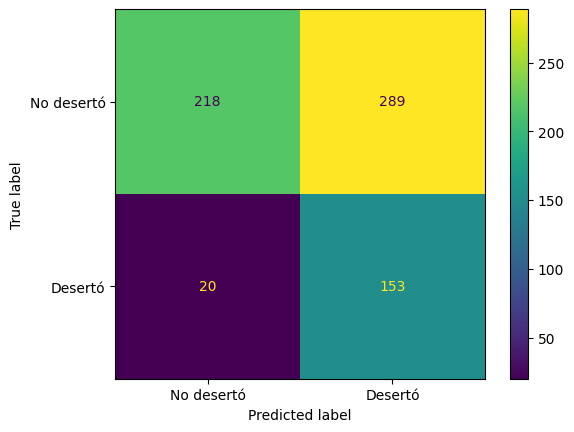

In [51]:
# Grilla de hiperparametros
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [
    'balanced',
    {0: 1, 1: 2},
    {0: 1, 1: 3}
    ],
    'max_iter': [200, 500, 1000]
}


grid_lr = GridSearchCV(LogisticRegression(random_state=82), param_grid_lr, cv=stratkf, scoring='recall')
grid_lr.fit(X_train_normalize, y_train)

print(grid_lr.best_params_)

# Eligiendo el mejor modelo
best_lr_no_smote = grid_lr.best_estimator_

best_lr_no_smote.fit(X_train_normalize, y_train)

# Analisis de metricas
y_pred = best_lr_no_smote.predict(X_val_normalize)
print(calcularMetricas(y_val, y_pred))
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Eligiendo el umbral optimo

In [52]:
y_proba = best_lr_no_smote.predict_proba(X_val_normalize)[:, 1]

In [53]:
y_proba.min(), y_proba.max()

(np.float64(0.4190711803628839), np.float64(0.6009936138394746))

In [54]:
thresholds = np.arange(0.4, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.40,0.254412,1.000000,0.405627,680
1,0.41,0.254412,1.000000,0.405627,680
2,0.42,0.255917,1.000000,0.407538,676
3,0.43,0.257440,1.000000,0.409467,672
4,0.44,0.258982,1.000000,0.411415,668
5,0.45,0.265337,1.000000,0.419394,652
6,0.46,0.271586,1.000000,0.427160,637
7,0.47,0.286190,0.994220,0.444444,601
8,0.48,0.297834,0.953757,0.453920,554
9,0.49,0.323108,0.913295,0.477341,489


### Umbral optimo: **0.52**

## Calibrando las probabilidades

In [55]:
lr_calibrado_no_smote = CalibratedClassifierCV(
    estimator=best_lr_no_smote,
    method="sigmoid",
    cv=5
)

In [56]:
# Entrenando el calibrador
lr_calibrado_no_smote.fit(X_train_normalize, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(C=0.01,
                                                    class_weight={0: 1, 1: 3},
                                                    max_iter=200, penalty='l1',
                                                    random_state=82,
                                                    solver='liblinear'))

In [57]:
y_proba_cal = lr_calibrado_no_smote.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [58]:
y_proba_cal.min(), y_proba_cal.max()

(np.float64(0.027465212751049805), np.float64(0.9491977001007996))

In [59]:
thresholds = np.linspace(y_proba_cal.min(), y_proba_cal.max(), 20)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.027465,0.254412,1.000000,0.405627,680
1,0.075977,0.306084,0.930636,0.460658,526
2,0.124490,0.307992,0.913295,0.460641,513
3,0.173002,0.326360,0.901734,0.479263,478
4,0.221514,0.340050,0.780347,0.473684,397
5,0.270026,0.337696,0.745665,0.464865,382
6,0.318539,0.336000,0.728324,0.459854,375
7,0.367051,0.365385,0.658960,0.470103,312
8,0.415563,0.383178,0.473988,0.423773,214
9,0.464075,0.379085,0.335260,0.355828,153


In [60]:
thresholds = np.arange(0.12, 0.3, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.12,0.307992,0.913295,0.460641,513
1,0.13,0.307992,0.913295,0.460641,513
2,0.14,0.307992,0.913295,0.460641,513
3,0.15,0.311637,0.913295,0.464706,507
4,0.16,0.321138,0.913295,0.475188,492
5,0.17,0.325678,0.901734,0.478528,479
6,0.18,0.328421,0.901734,0.481481,475
7,0.19,0.331210,0.901734,0.484472,471
8,0.20,0.340858,0.872832,0.490260,443
9,0.21,0.339806,0.809249,0.478632,412


### Umbral optimo: **0.20**

In [61]:
umbral_lr_cal = 0.2

In [62]:
# Test con el conjunto de prueba

y_proba = lr_calibrado_no_smote.predict_proba(X_test)[:, 1]

y_pred = (y_proba >= umbral_lr_cal).astype(int)

print(calcularMetricas(y_test, y_pred))

{'Accuracy': 0.5018, 'F1': 0.4687, 'Recall': 0.8657, 'Precision': 0.3213}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Nombre de los modelos:

Modelo sin calibrar: **best_lr_no_smote**

Modelo calibrado: **lr_calibrado_no_smote**

# Modelo XGBOOST

In [63]:
# Segmentación de datos

X_temp, X_test, y_temp, y_test = train_test_split(X, y, random_state=82, stratify=y, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, random_state=82, stratify=y_temp, test_size=0.2)

In [64]:
# Balanceo de clases

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [65]:
# Creando el modelo

modelo_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    n_estimators=300,
    learning_rate=0.05,
    random_state=82
)

modelo_xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

## Analisis de metricas / Matriz de confusión

In [66]:
pipeline = Pipeline([('oversample', SMOTE()), ('xgb', modelo_xgb)])
validacion = cross_val_score(pipeline, X_temp, y_temp, cv=stratkf, scoring='recall')
print(intervalo_confianza(validacion, 'xgb'))

intervalo de confianza, modelo xgb: [0.24858503739706034, 0.33076702605232794]


{'Accuracy': 0.7353, 'F1': 0.3662, 'Recall': 0.3006, 'Precision': 0.4685}


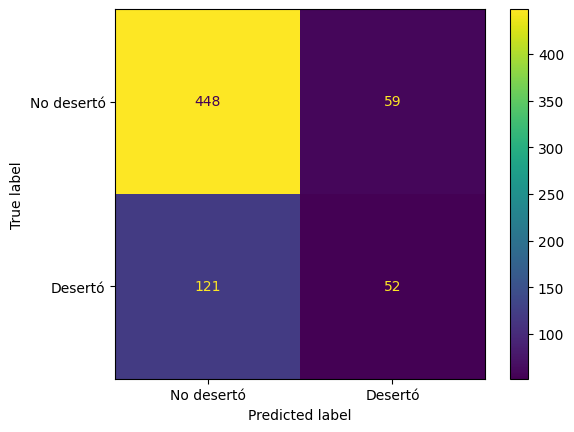

In [67]:
y_pred = modelo_xgb.predict(X_val)
print(calcularMetricas(y_val ,y_pred))

visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Optimización de hiperparametros

In [68]:
param_xgb = {
    "max_depth": [2, 3, 4, 5],
    "min_child_weight": [1, 5, 10],
    "subsample": np.linspace(0.6, 0.9, 4),
    "colsample_bytree": np.linspace(0.6, 0.9, 4)
}

random_search = RandomizedSearchCV(
    estimator=modelo_xgb,
    param_distributions=param_xgb,
    n_iter=30,
    scoring="average_precision",
    cv=5,
    random_state=82,
    n_jobs=-1,
    verbose=1
)

In [69]:
random_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=300, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9]),
                                        'max_depth': [2, 3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': array([0.6, 0.7, 0.8, 0.9])},
                   random_state=82, scoring='average_precision', verbose=1)

In [70]:
# viendo los mejores parametros
random_search.best_params_

{'subsample': np.float64(0.6),
 'min_child_weight': 1,
 'max_depth': 2,
 'colsample_bytree': np.float64(0.8)}

In [71]:
# seleccionando el mejor estimador
best_xgb = random_search.best_estimator_

In [72]:
best_xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

## Eligiendo el umbral

In [73]:
y_proba = best_xgb.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.2, 0.4, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.20,0.399471,0.872832,0.548094,378
1,0.21,0.406077,0.849711,0.549533,362
2,0.22,0.421512,0.838150,0.560928,344
3,0.23,0.426866,0.826590,0.562992,335
4,0.24,0.425926,0.797688,0.555332,324
5,0.25,0.429022,0.786127,0.555102,317
6,0.26,0.439739,0.780347,0.562500,307
7,0.27,0.442953,0.763006,0.560510,298
8,0.28,0.445614,0.734104,0.554585,285
9,0.29,0.441606,0.699422,0.541387,274


### Umbral optimo: **0.23**

In [74]:
umbral_xgb = 0.23

In [75]:
y_proba_val = best_xgb.predict_proba(X_val)[:, 1]
y_pred_val = (y_proba_val >= umbral_xgb).astype(int)

In [76]:
metricas_val = calcularMetricas(y_val, y_pred_val)
print(metricas_val)

{'Accuracy': 0.6735, 'F1': 0.563, 'Recall': 0.8266, 'Precision': 0.4269}


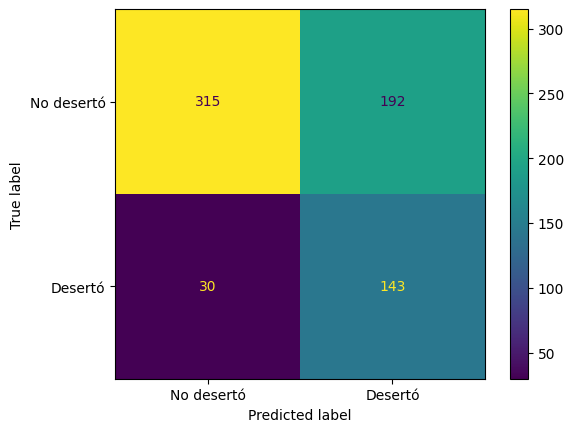

In [77]:
visualizer = matriz_confusion(y_val, y_pred_val)
plt.show()

## Feature Importances + Feature Selection

In [78]:
booster = best_xgb.get_booster()

importancias = booster.get_score(importance_type='gain')

In [79]:
importancias_xgb = (
    pd.DataFrame(importancias.items(), columns=["Feature", "Gain"])
    .sort_values("Gain", ascending=False)
)

In [80]:
importancias_xgb["Gain_%"] = (
    importancias_xgb["Gain"] /
    importancias_xgb["Gain"].sum() * 100
)

In [81]:
importancias_xgb

,Feature,Gain,Gain_%
5,onehotencoder__tipo_contrato_mensual,54.186230,14.618288
12,remainder__facturas_impagas,39.185371,10.571377
3,onehotencoder__metodo_pago_tarjeta_debito,36.281349,9.787933
2,onehotencoder__metodo_pago_tarjeta_credito,32.122932,8.666081
1,onehotencoder__plan_premium,31.359858,8.460220
7,onehotencoder__canal_adquisicion_referido,28.322624,7.640839
11,remainder__cambios_plan,20.784979,5.607344
0,onehotencoder__plan_estandar,19.960312,5.384866
6,onehotencoder__canal_adquisicion_redes_sociales,17.289635,4.664374
4,onehotencoder__metodo_pago_transferencia_bancaria,16.402857,4.425141


In [82]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_df = pd.DataFrame(X_train_smote, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_df = pd.DataFrame(X_val, columns=df_codificado.drop(columns='churn', axis=1).columns)

model_features = random_search.best_estimator_

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]

for i in ct_features:

    selected_features = importancias_xgb['Feature'].values[:i]
    X_train_sel = X_train_df[selected_features]
    X_val_sel = X_val_df[selected_features]

    model_features = clone(random_search.best_estimator_)
    model_features.fit(X_train_sel, y_train_smote)

    y_proba = model_features.predict_proba(X_val_sel)[:, 1]
    y_pred_val = (y_proba >= umbral_xgb).astype(int)

    metricas = calcularMetricas(y_val, y_pred_val)
    resultados[i] = list(metricas.values())

print(resultados)

               1       2       3       4       5       6       7       8   \
Accuracy   0.4588  0.5176  0.5382  0.5691  0.5809  0.6044  0.6044  0.6029   
F1         0.4338  0.4843  0.4886  0.4974  0.4991  0.5064  0.5009  0.5000   
Recall     0.8150  0.8902  0.8671  0.8382  0.8208  0.7977  0.7803  0.7803   
Precision  0.2956  0.3326  0.3401  0.3537  0.3586  0.3710  0.3689  0.3678   

               9       10      11      12      13      14      15      16  \
Accuracy   0.6088  0.6088  0.6368  0.6353  0.6353  0.6338  0.6515  0.6706   
F1         0.5000  0.5019  0.5277  0.5249  0.5231  0.5221  0.5362  0.5538   
Recall     0.7688  0.7746  0.7977  0.7919  0.7861  0.7861  0.7919  0.8035   
Precision  0.3705  0.3712  0.3943  0.3926  0.3919  0.3908  0.4053  0.4225   

               17      18  
Accuracy   0.6676  0.6647  
F1         0.5569  0.5564  
Recall     0.8208  0.8266  
Precision  0.4214  0.4194  


## Features optimas: 6

In [83]:
xgb_features = importancias_xgb['Feature'].values[:6]

In [84]:
X_selected_features = df_codificado[xgb_features]

In [85]:
print(xgb_features)

['onehotencoder__tipo_contrato_mensual' 'remainder__facturas_impagas'
 'onehotencoder__metodo_pago_tarjeta_debito'
 'onehotencoder__metodo_pago_tarjeta_credito'
 'onehotencoder__plan_premium' 'onehotencoder__canal_adquisicion_referido']


In [86]:
# Segmentando los datos con las mejores features

X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, random_state=82, stratify=y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.2, random_state=82)

In [87]:
# Balanceo de clases

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [88]:
modelo_xgb = clone(random_search.best_estimator_)
modelo_xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [89]:
y_proba = modelo_xgb.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.3, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.30,0.343891,0.878613,0.494309,442
1,0.31,0.343964,0.872832,0.493464,439
2,0.32,0.343964,0.872832,0.493464,439
3,0.33,0.347926,0.872832,0.497529,434
4,0.34,0.347418,0.855491,0.494157,426
5,0.35,0.352798,0.838150,0.496575,411
6,0.36,0.353808,0.832370,0.496552,407
7,0.37,0.353808,0.832370,0.496552,407
8,0.38,0.353086,0.826590,0.494810,405
9,0.39,0.361323,0.820809,0.501767,393


### Umbral optimo: **0.4**

In [90]:
umbral_xgb = 0.4

In [91]:
y_proba_val = modelo_xgb.predict_proba(X_val)[:, 1]

In [92]:
y_pred = (y_proba_val >= umbral_xgb).astype(int)

In [93]:
metricas_val = calcularMetricas(y_val, y_pred)
print(metricas_val)

{'Accuracy': 0.5853, 'F1': 0.5018, 'Recall': 0.8208, 'Precision': 0.3613}


## Calibración

In [94]:
xgb_calibrado = CalibratedClassifierCV(
    estimator=modelo_xgb,
    method='sigmoid',
    cv=5
)

xgb_calibrado.fit(X_train_smote, y_train_smote)

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=np.float64(0.8),
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='aucpr',
                                               feature_types=None,
                                               feature_weights=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.05, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=2,
                                               max_leaves=None,
                                               min_child_weight=1, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=None,
                                               num_parallel_tree=None, ...))

In [95]:
# Obteniendo las probabilidades calibradas

y_proba_cal = xgb_calibrado.predict_proba(X_val)[:, 1]

In [96]:
thresholds = np.arange(0.3, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.30,0.343964,0.872832,0.493464,439
1,0.31,0.348837,0.867052,0.497512,430
2,0.32,0.354217,0.849711,0.500000,415
3,0.33,0.353808,0.832370,0.496552,407
4,0.34,0.353808,0.832370,0.496552,407
5,0.35,0.361323,0.820809,0.501767,393
6,0.36,0.361323,0.820809,0.501767,393
7,0.37,0.361323,0.820809,0.501767,393
8,0.38,0.360825,0.809249,0.499109,388
9,0.39,0.360825,0.809249,0.499109,388


### Umbral optimo: 0.46

In [97]:
umbral_xgb_calibrado = 0.46

In [98]:
# Testing con el conjunto de prueba

y_proba_test = xgb_calibrado.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= umbral_xgb_calibrado).astype(int)

metricas_test = calcularMetricas(y_test, y_pred_test)
print(metricas_test)

{'Accuracy': 0.6404, 'F1': 0.5174, 'Recall': 0.7593, 'Precision': 0.3923}


# Modelo XGBOOST sin SMOTE ni scale_pos_weight

## Segmentación de datos

In [135]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=82)

In [136]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=82)

# Creando y entrenando el modelo base

In [139]:
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    n_estimators=300,
    learning_rate=0.05,
    random_state=82
)

In [140]:
xgb_base.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

## Analisis de metricas / Matriz de confusión

In [141]:
y_pred = xgb_base.predict(X_val)
print(calcularMetricas(y_val, y_pred))

{'Accuracy': 0.7294, 'F1': 0.3521, 'Recall': 0.289, 'Precision': 0.4505}


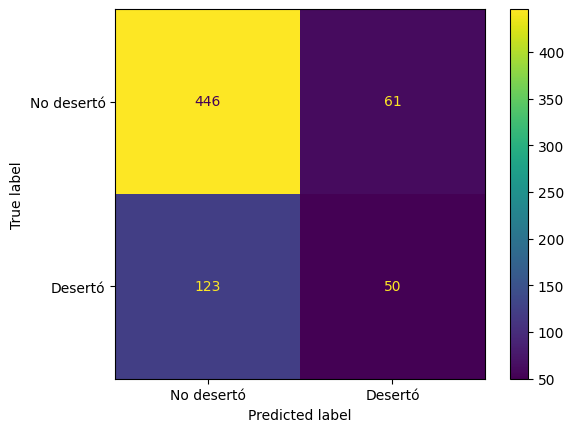

In [142]:
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Optimización de hiperparametros

In [143]:
param_grid_xgb = {
    'n_estimators': [200, 300, 400, 600],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid_xgb,
    n_iter=30,
    scoring="average_precision",
    cv=5,
    random_state=82,
    n_jobs=-1,
    verbose=1
)

In [144]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [200, 300, 400, 600],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2, 3],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=82, scoring='average_precision', verbose=1)

In [145]:
# mejores parametros

random_search.best_params_

{'subsample': 0.8,
 'reg_lambda': 1.5,
 'reg_alpha': 0.01,
 'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.03,
 'gamma': 0,
 'colsample_bytree': 0.9}

In [146]:
# mejor estimador

best_xgb_sbc = random_search.best_estimator_

In [147]:
best_xgb_sbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

## Eligiendo el umbral

In [150]:
y_proba = best_xgb_sbc.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.1, 0.3, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.10,0.324427,0.982659,0.487805,524
1,0.11,0.328713,0.959538,0.489676,505
2,0.12,0.334694,0.947977,0.494721,490
3,0.13,0.345416,0.936416,0.504673,469
4,0.14,0.351648,0.924855,0.509554,455
5,0.15,0.355204,0.907514,0.510569,442
6,0.16,0.363636,0.901734,0.518272,429
7,0.17,0.374083,0.884393,0.525773,409
8,0.18,0.392308,0.884393,0.543517,390
9,0.19,0.402116,0.878613,0.551724,378


### Umbral optimo : **0.2**

In [151]:
umbral_xgb_sbc = 0.2

In [152]:
y_pred = (y_proba >= 0.2).astype(int)

In [153]:
print(calcularMetricas(y_val, y_pred))

{'Accuracy': 0.65, 'F1': 0.5593, 'Recall': 0.8728, 'Precision': 0.4114}


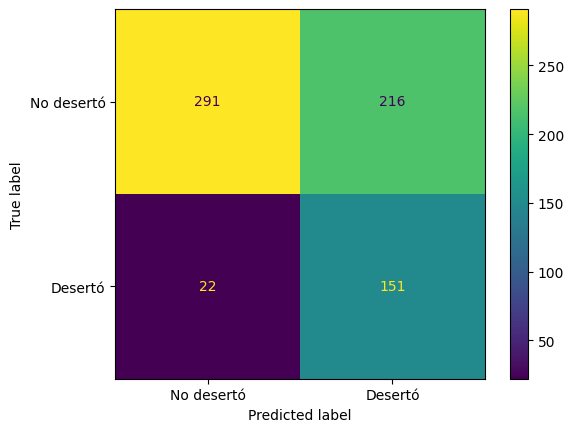

In [154]:
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Feature Importances + Feature Selection

## Calibración

# Modelo RandomForest

In [99]:
# Separación de datos
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, random_state=82, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=82, test_size=0.2)

In [100]:
# Balanceo de clases

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [101]:
# Creando el modelo
modelo_forest = RandomForestClassifier(random_state=82, n_estimators=100, min_samples_leaf=3, min_samples_split=5, max_depth=5)

modelo_forest.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=5,
                       random_state=82)

## Analisis de metricas / Matriz de confusión

In [102]:
pipeline = Pipeline([('oversample', SMOTE()), ('xgb', modelo_forest)])
validacion = cross_val_score(pipeline, X_temp, y_temp, cv=stratkf, scoring='recall')
print(intervalo_confianza(validacion, 'forest'))

intervalo de confianza, modelo forest: [0.41345070102723, 0.5483586819543536]


In [103]:
y_pred = modelo_forest.predict(X_val)
metricasForest = calcularMetricas(y_val, y_pred)

print(metricasForest)

{'Accuracy': 0.7382, 'F1': 0.4606, 'Recall': 0.4393, 'Precision': 0.4841}


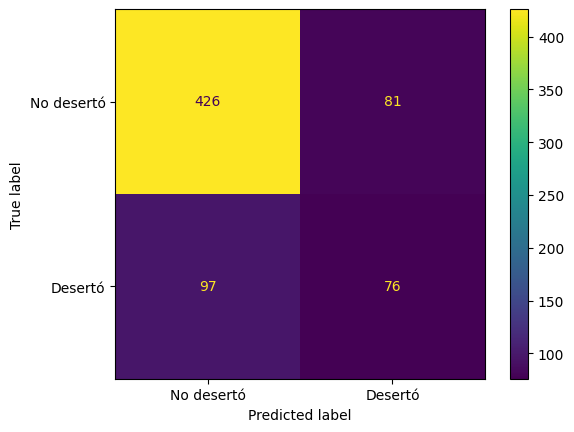

In [104]:
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Optimización de parametros

In [105]:
scorer = make_scorer(recall_score)

In [106]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [107]:
random_search = RandomizedSearchCV(
    estimator=modelo_forest,
    param_distributions=param_dist,
    n_iter=50,            # número de combinaciones aleatorias
    scoring=scorer,
    cv=5,                 # cross-validation
    verbose=2,
    random_state=82,
    n_jobs=-1
)

In [108]:
random_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=5,
                                                    min_samples_leaf=3,
                                                    min_samples_split=5,
                                                    random_state=82),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=82,
                   scoring=make_scorer(recall_score, response_method='predict'),
                   verbose=2)

In [109]:
# Viendo los mejores parametros
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': True}

In [110]:
# Seleccionando el mejor estimador
best_rf = random_search.best_estimator_

In [111]:
best_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=200,
                       random_state=82)

## Eligiendo el umbral

In [112]:
y_proba = best_rf.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.2, 0.4, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.20,0.299308,1.000000,0.460719,578
1,0.21,0.304425,0.994220,0.466125,565
2,0.22,0.309353,0.994220,0.471879,556
3,0.23,0.312500,0.982659,0.474198,544
4,0.24,0.317757,0.982659,0.480226,535
5,0.25,0.325670,0.982659,0.489209,522
6,0.26,0.333333,0.976879,0.497059,507
7,0.27,0.339431,0.965318,0.502256,492
8,0.28,0.345992,0.947977,0.506955,474
9,0.29,0.347345,0.907514,0.502400,452


### Umbral optimo: **0.37**

In [113]:
umbral_rf = 0.37

In [114]:
y_proba_val = best_rf.predict_proba(X_val)[:, 1]
y_pred = (y_proba_val >= umbral_rf).astype(int)

In [115]:
print(calcularMetricas(y_val, y_pred))

{'Accuracy': 0.6529, 'F1': 0.5261, 'Recall': 0.7572, 'Precision': 0.4031}


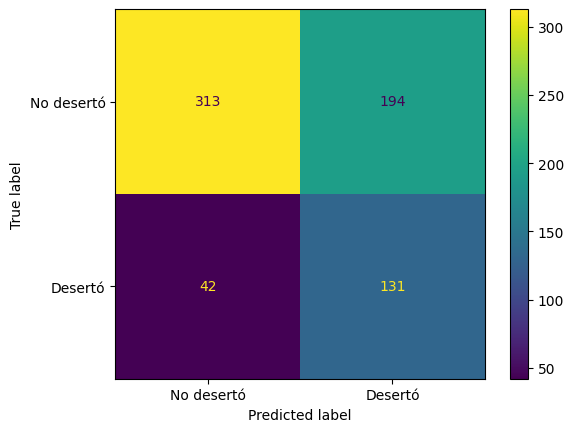

In [116]:
visualizer = matriz_confusion(y_val, y_pred)
plt.show()

## Feature Importances + Feature Selection

In [117]:
# Convertimos X_train_smote y X_val a df para seleccionar las features
X_train_df = pd.DataFrame(X_train_smote, columns=df_codificado.drop(columns='churn', axis=1).columns)
X_val_df = pd.DataFrame(X_val, columns=df_codificado.drop(columns='churn', axis=1).columns)

importancias = best_rf.feature_importances_
ft_importances = pd.DataFrame({'Features': df_codificado.drop(columns='churn', axis=1).columns,
                               'Importancia': (importancias*100).round(2)}).sort_values('Importancia', ascending=False)

print(ft_importances)

resultados = pd.DataFrame(index=['Accuracy', 'F1', 'Recall', 'Precision'])

ct_features = [i for i in range(1, 19)]

for i in ct_features:

    selected_features = ft_importances['Features'].values[:i]
    X_train_sel = X_train_df[selected_features]
    X_val_sel = X_val_df[selected_features]

    model_features = clone(random_search.best_estimator_)
    model_features.fit(X_train_sel, y_train_smote)

    y_proba = model_features.predict_proba(X_val_sel)[:, 1]
    y_pred_val = (y_proba >= umbral_rf).astype(int)

    metricas = calcularMetricas(y_val, y_pred_val)
    resultados[i] = list(metricas.values())

print(resultados)

                                             Features  Importancia
12                        remainder__facturas_impagas        24.24
5                onehotencoder__tipo_contrato_mensual        18.83
3           onehotencoder__metodo_pago_tarjeta_debito         7.08
11                            remainder__cambios_plan         6.94
1                         onehotencoder__plan_premium         6.61
7           onehotencoder__canal_adquisicion_referido         6.50
2          onehotencoder__metodo_pago_tarjeta_credito         6.36
4   onehotencoder__metodo_pago_transferencia_bancaria         3.87
18                         remainder__premium_mensual         3.22
0                        onehotencoder__plan_estandar         2.97
10                          remainder__frecuencia_uso         2.48
14                   remainder__friccion_del_servicio         2.45
9                               remainder__antiguedad         2.08
6     onehotencoder__canal_adquisicion_redes_sociales         

## Features optimas: 5

In [118]:
rf_features = ft_importances['Features'].values[:5]
rf_features

array(['remainder__facturas_impagas',
       'onehotencoder__tipo_contrato_mensual',
       'onehotencoder__metodo_pago_tarjeta_debito',
       'remainder__cambios_plan', 'onehotencoder__plan_premium'],
      dtype=object)

In [119]:
X_selected_features = df_codificado[rf_features]

## Segmentando con las features optimas

In [120]:
X_temp, X_test, y_temp, y_test = train_test_split(X_selected_features, y, random_state=82, stratify=y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, random_state=82, stratify=y_temp, test_size=0.2)

In [121]:
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [122]:
modelo_rf = clone(random_search.best_estimator_)

In [123]:
modelo_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=200,
                       random_state=82)

## Eligiendo el umbral

In [124]:
y_proba_val = modelo_rf.predict_proba(X_val)[:, 1]

In [125]:
rows = []


thresholds = np.arange(0.3, 0.6, 0.01)

for t in thresholds:
    y_pred = (y_proba_val >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.30,0.336303,0.872832,0.485531,449
1,0.31,0.337054,0.872832,0.486312,448
2,0.32,0.340858,0.872832,0.490260,443
3,0.33,0.343458,0.849711,0.489185,428
4,0.34,0.346793,0.843931,0.491582,421
5,0.35,0.346793,0.843931,0.491582,421
6,0.36,0.346988,0.832370,0.489796,415
7,0.37,0.350746,0.815029,0.490435,402
8,0.38,0.350746,0.815029,0.490435,402
9,0.39,0.350746,0.815029,0.490435,402


### Umbral optimo: **0.5**

In [126]:
umbral_rf = 0.5

In [127]:
y_proba = modelo_rf.predict_proba(X_val)[:, 1]
y_pred = (y_proba >= umbral_rf).astype(int)

In [128]:
print(calcularMetricas(y_val, y_pred))

{'Accuracy': 0.6147, 'F1': 0.5019, 'Recall': 0.763, 'Precision': 0.3739}


## Calibración

In [129]:
rf_calibrado = CalibratedClassifierCV(
    estimator = modelo_rf,
    method = 'sigmoid',
    cv = 5
)

In [130]:
rf_calibrado.fit(X_train_smote, y_train_smote)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(max_depth=5,
                                                        min_samples_split=10,
                                                        n_estimators=200,
                                                        random_state=82))

In [131]:
y_proba_cal = rf_calibrado.predict_proba(X_val)[:, 1]

In [132]:
thresholds = np.arange(0.3, 0.6, 0.01)

rows = []

for t in thresholds:
    y_pred = (y_proba_cal >= t).astype(int)

    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "positivos_predichos": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
df_thresholds

,threshold,precision,recall,f1,positivos_predichos
0,0.30,0.347087,0.826590,0.488889,412
1,0.31,0.349754,0.820809,0.490501,406
2,0.32,0.350746,0.815029,0.490435,402
3,0.33,0.352645,0.809249,0.491228,397
4,0.34,0.352645,0.809249,0.491228,397
5,0.35,0.352645,0.809249,0.491228,397
6,0.36,0.352792,0.803468,0.490300,394
7,0.37,0.352792,0.803468,0.490300,394
8,0.38,0.352792,0.803468,0.490300,394
9,0.39,0.352792,0.803468,0.490300,394


### Umbral optimo: 0.52

In [133]:
umbral_rf_cal = 0.52

In [134]:
# testing con el conjunto de prueba

y_proba_test = rf_calibrado.predict_proba(X_test)[:, 1]
y_pred = (y_proba_test >= umbral_rf_cal).astype(int)

print(calcularMetricas(y_test, y_pred))

{'Accuracy': 0.6204, 'F1': 0.4992, 'Recall': 0.7454, 'Precision': 0.3753}
